# <center>R5.A.11 - Méthodes d'optimisation <br> TP4 - Algorithme de recommandation<center>


_Tom Ferragut, Thibault Godin_

_IUT de Vannes, BUT Informatique_


Ce TP est inspiré d'une première version de l'algorithme de recommandation utilisé par la société [**Mediego**](https://www.mediego.com/fr/).

### imports


In [1]:
# importation des packages
import numpy as np
import pandas as pd
import random
import math
import time

# importation des modules
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable


## 0 - Introduction
### 0.a - La méthode de recommandation


__________________________________________
Les __algorithmes de recommandation__ jouent un rôle central sur internet,  ils sont notamment utilisés _(par Youtube, Netflix, Amazon, ...)_ pour vous recommander des vidéos, films, produits etc... Leur principe général est de proposer un ou plusieurs éléments d'un ensemble que l'utilisateur serait susceptible d'apprécier.

Les méthodes de recommandations sont variées, mais la plupart analysent les comportements antérieurs de l'utilisateur (__son historique__) pour anticiper ses préférences futures. 
___________________________________________

Le __premier objectif__ de ce TP est d'implémenter un algorithme de recommandation qui, basé sur les données `notes_films.tsv` que vous avez fournis, vous proposera un film à regarder qui "a des chances de vous plaire".

Cette méthode fonctionne de la façon suivante :
1) À partir d'un __utilisateur__ et de son __historique__, on détermine ses __voisins__, d'autres utilisateurs _similaires_ (ayant par exemple un historique proche de l'utilisateur).
2) On cherche dans le __voisinage__ de l'utilisateur, le __film__ le plus souvent visionné _(où ayant les meilleurs notes)_. Ce film sera la recommandation faite par notre algorithme.

Cette recommandation dépend entièrement de comment l'on détermine que deux utilisateurs sont proches, c'est à dire que la recommandation dépend de la distance que l'on a choisi entre les utilisateurs. Le __deuxième objectif__ du TP est de comparer différents choix de distances sur les utilisateurs en estimant dans chaque cas la pertinence de notre méthode.


### 0.b - Vos données !

Merci de votre participation au Framaform ! On importe ces données `notes_film.tsv` grâce au package `pandas`. Chaque utilisateur est repéré par son index ainsi que par son _numéro étudiant_. Dans ces données, un film _non regardé_ est représenté par une note de $-1$

In [16]:
# importation du fichier
data = pd.read_csv("notes_films.tsv", sep="\t")
# 5 premières lignes des données
data.head()

number_movies = 58
number_users = 52

# Liste des numéros étudiants
print(data["Numéro étudiant (pour traitement des données)."].head())

# Liste des notes de l'utilisateur 0
print(data.iloc[0].head())
# Note du film 1 de l'utilisateur 0
print(data.iloc[1, 0])


0      19162570
1        565656
2      52000535
3    1234567890
4       2001490
Name: Numéro étudiant (pour traitement des données)., dtype: int64
Numéro étudiant (pour traitement des données).    19162570.0
Aladdin                                                 -1.0
Aliens : Le Retour                                      -1.0
Arrête-moi si tu peux                                    3.0
Avengers: Endgame                                       -1.0
Name: 0, dtype: float64
565656


In [17]:
data.head()
np.isnan(data.iloc[7, 10])


np.True_

La fonction suivante permet d'afficher vos données sous forme de _heatmap_. Cela peut nous donner une idée qualitative de la répartition des notes sur chacun des films.

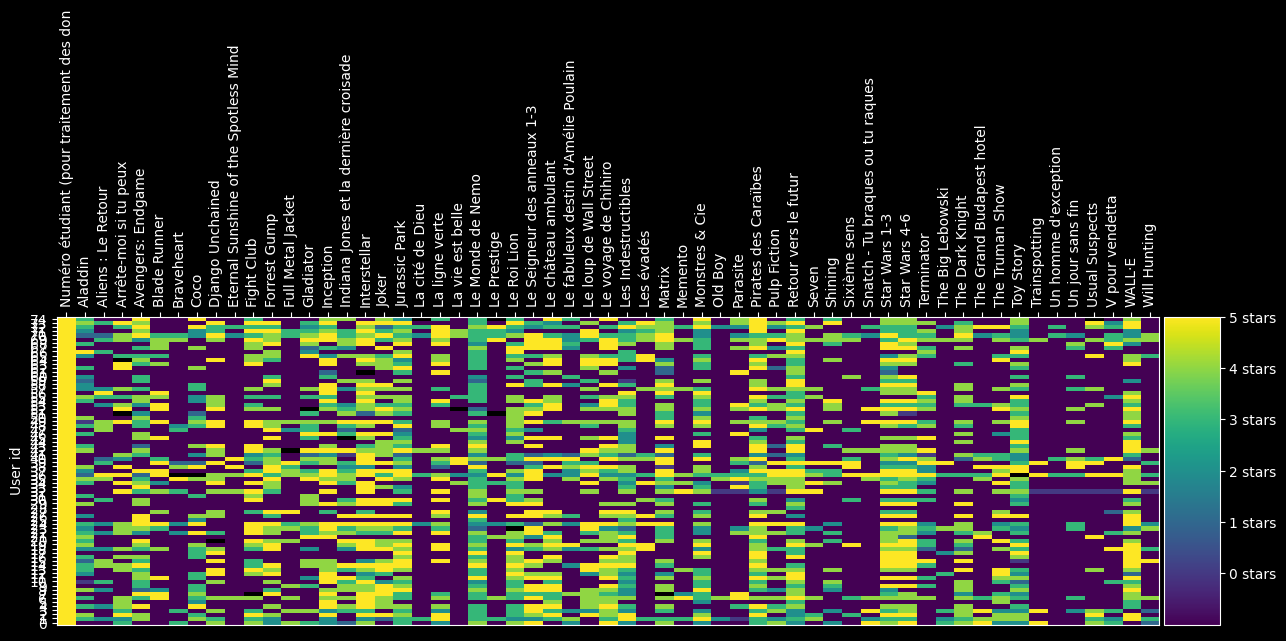

In [14]:
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    # Reverse to match the order of the printed dataframe
    # most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]

    fig = plt.figure(figsize=(15, 4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(
        most_rated_movies_users_selection,
        interpolation="nearest",
        vmin=-1,
        vmax=5,
        aspect="auto",
    )

    if axis_labels:
        ax.set_yticks(
            np.arange(most_rated_movies_users_selection.shape[0]), minor=False
        )
        ax.set_xticks(
            np.arange(most_rated_movies_users_selection.shape[1]), minor=False
        )
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel("User id")

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(
        ["5 stars", "4 stars", "3 stars", "2 stars", "1 stars", "0 stars"]
    )

    plt.show()


draw_movies_heatmap(data)


## 1 - Implémentation de l'algorithme

### 1.a - Distance entre utilisateurs par historique commun

La première distance entre utilisateurs que l'on choisi est celle qui compte le nombre de films vus en commun. 

Pour cela, voici une première fonction qui donne la liste des films vus par un utilisateur.

In [15]:
def historic_index(user, dictionnary=data):
    user = int(user)
    # Initialisation de la liste des films
    historic_index = set()
    stars = set([0, 1, 2, 3, 4, 5])
    for movie in range(number_movies):
        # On vérifie si une note a bien été donné à 'movie'
        if dictionnary.iloc[user, movie + 1] == "nan" or np.isnan(
            dictionnary.iloc[user, movie + 1]
        ):
            dictionnary.iloc[user, movie + 1] = -1
        elif dictionnary.iloc[user, movie + 1] in stars:
            historic_index.add(movie + 1)
        elif dictionnary.iloc[user, movie + 1] == -1:
            pass
        else:
            print("?", dictionnary.iloc[user, movie + 1], user, movie + 1)
            dictionnary.iloc[user, movie + 1] = -1

    return historic_index


> __Question 1:__ Écrire une fonction `distance_historic_1` qui, étant donnés deux utilisateurs `user_1` et `user_2`, nous donne le nombre de films qu'ils ont vu en commun.

In [25]:
def distance_historic_1(user_1, user_2, dictionnary=data):
    """
    Calcule la distance entre deux utilisateurs en fonction du nombre de films qu'ils ont vus en commun.
    """

    # Récupération de l'historique des deux utilisateurs
    historic_1 = historic_index(user_1, dictionnary)
    historic_2 = historic_index(user_2, dictionnary)

    # Intersection des deux ensembles pour trouver les films vus en commun
    common_movies = historic_1.intersection(historic_2)

    # Distance est simplement la taille de l'intersection (nombre de films en commun)
    distance = len(common_movies)

    return distance


try:
    assert distance_historic_1(0, 1) == 30
    assert distance_historic_1(15, 41) == 22
    print("distance_historic_1 : OK")
except:
    print("distance_historic_1 : ERREUR")


distance_historic_1 : OK


Cette distance à des limites, par exemple un utilisateur ayant vu la totalité des films sera proche de chaque autre utilisateur. La distance suivante prend en compte ce cas de figure en considérant également le nombre total de films vus par les deux utilisateurs, ainsi deux utilisateurs ayant vu exactement les même films seront identifiés pour cette distance.

> __Question 2:__ Écrire une fonction `distance_historic_2` qui, étant donnés deux utilisateurs `user_1` et `user_2`, nous donne le rapport $\dfrac{\text{taille de l'intersection}}{\text{taille de l'union} +1}$ de leur historique.

In [19]:
def distance_historic_2(user_1, user_2, dictionnary=data):
    """
    Calcule la distance entre deux utilisateurs basée sur le rapport
    taille de l'intersection / (taille de l'union + 1) de leur historique de films.
    """

    # Récupérer les historiques des deux utilisateurs
    historic_1 = historic_index(user_1, dictionnary)
    historic_2 = historic_index(user_2, dictionnary)

    # Calculer l'intersection et l'union des ensembles
    intersection_size = len(historic_1.intersection(historic_2))
    union_size = len(historic_1.union(historic_2))

    # Calcul de la distance selon la formule donnée
    distance = intersection_size / (union_size + 1)

    return distance


try:
    assert distance_historic_2(0, 3) == 0.875
    assert distance_historic_2(41, 31) == 1 / 6
    print("distance_historic_2 : OK")
except:
    print("distance_historic_2 : ERREUR")


distance_historic_2 : OK


Nous construisons maintenant le voisinage d'un utilisateur `user` contenant `k` voisins.

__Attention !__ Dans la fonction suivante on cherche à _maximiser_ la fonction `distance_historic_1(ou 2)` parmis les autres utilisateurs.

> __Question 3:__ Écrire une fonction `neighborhood_I` qui étant donné un utilisateurs `user`, un nombre de voisins `k` et une distance entre voisins `distance` nous donne la liste des `k` voisins ayant la plus grande distance avec `user`. Pour le test, cette liste doit être triée par distance.  

In [31]:
def neighborhood_I(user, k=3, distance=distance_historic_1, dictionnary=data):
    """
    Trouve les k voisins les plus proches de l'utilisateur donné en fonction d'une distance spécifique.

    INPUTS:
    - user : l'utilisateur dont on cherche les voisins
    - k : nombre de voisins à retourner
    - distance : fonction de distance entre les utilisateurs (par défaut : distance_historic_1)
    - dictionnary : les données (par défaut : data)

    OUTPUTS:
    - Liste des indices des k voisins triés par distance décroissante
    """

    # On initialise une liste vide pour stocker les distances des voisins potentiels
    neighborhood = []

    for new_user in range(number_users):
        if new_user != user:  # On ne compare pas l'utilisateur avec lui-même
            dist = distance(user, new_user, dictionnary)
            neighborhood.append(
                [new_user, dist]
            )  # On stocke l'utilisateur et sa distance

    # Trier les voisins par distance décroissante
    neighborhood.sort(key=lambda x: x[1], reverse=True)

    # Retourner les k premiers voisins (on ne garde que les indices des utilisateurs)
    return [neighbor[0] for neighbor in neighborhood[:k]]


# Test la fonction 'neighborhood_I'
try:
    assert neighborhood_I(3, 8) == [36, 0, 24, 49, 1, 6, 22, 32]
    assert neighborhood_I(15, 5) == [22, 24, 36, 49, 1]
    assert neighborhood_I(27, 2) == [36, 49]
    print("neighborhood_I : OK")
except:
    print("neighborhood_I : ERREUR")


neighborhood_I : OK


Une fois le voisinage construit, on cherche le film apparaissant le plus dans l'historique des voisins. C'est ce film que l'algorithme recommandera. Pour cela on définie une fonction `item_score`, qui compte le nombre de fois que le film `item` apparait `neighborhood`.

> __Question 4:__ Définir une fonction `item_score_I` qui renvoie le nombre de fois que le film `movie` apparait dans l'historique des voisins de `neighborhood`.

In [32]:
def item_score_I(movie, user, neighborhood, dictionnary=data):
    """
    Compte combien de fois le film 'movie' apparaît dans l'historique des voisins de 'neighborhood'.

    INPUTS:
    - movie : le film dont on cherche à compter les apparitions
    - user : l'utilisateur dont on cherche à construire le voisinage
    - neighborhood : liste des indices des voisins de 'user'
    - dictionnary : les données (par défaut : data)

    OUTPUTS:
    - item_score : nombre de fois que le film 'movie' apparaît dans l'historique des voisins
    """

    item_score = 0  # Initialisation du score

    for neighbor in neighborhood:
        # Récupérer l'historique de l'utilisateur 'neighbor'
        neighbor_historic = historic_index(neighbor, dictionnary)

        # Vérifier si le film 'movie' est dans l'historique
        if movie in neighbor_historic:
            item_score += 1  # Incrémenter le score si le film est présent

    return item_score


# Test la fonction 'item_score_I'
try:
    assert item_score_I(40, 17, neighborhood_I(17, k=6)) == 2
    assert item_score_I(25, 24, neighborhood_I(24, k=6)) == 6
    print("item_score_I : OK")
except:
    print("item_score_I : ERREUR")


item_score_I : OK


Nous avons toutes les pièces du puzzle, nous pouvons maintenant écrire la fonction `recommandation`.

> __Question 5:__ Écrire une fonction `recommandation` qui, étant donné un utilisateur `user`, un nombre de voisins `k` et une `distance` entre utilisateur, renvoie l'indice du film que vérifie :
> - Valeur de `item_score_I` la plus élevée
> - Non vu par `user`  

In [33]:
def recommandation(user, k, distance=distance_historic_1, dictionnary=data, mod=1):
    """
    Recommande un film à l'utilisateur 'user' en fonction des films les plus vus par ses voisins.

    INPUTS:
    - user : l'utilisateur pour lequel on souhaite faire une recommandation
    - k : le nombre de voisins à prendre en compte
    - distance : la fonction de distance à utiliser (par défaut : distance_historic_1)
    - dictionnary : les données (par défaut : data)

    OUTPUTS:
    - L'indice du film recommandé (celui avec le score le plus élevé parmi ceux non vus par l'utilisateur)
    """

    # Initialisation du score maximal et du film recommandé
    current_score = 0
    recommendation = [-1, current_score]

    # Construire la liste des films non vus par l'utilisateur
    user_historic = historic_index(user, dictionnary)
    not_seen_movies = [
        movie for movie in range(1, number_movies + 1) if movie not in user_historic
    ]

    # Construire le voisinage
    neighborhood = neighborhood_I(user, k, distance, dictionnary)

    # Pour chaque film non vu, calculer le score avec les voisins
    for movie in not_seen_movies:
        movie_score = item_score_I(movie, user, neighborhood, dictionnary)

        # Si le score du film est plus élevé que le score actuel, on met à jour la recommandation
        if movie_score > current_score:
            recommendation = [movie, movie_score]
            current_score = movie_score

    return recommendation[0]  # Retourne l'indice du film recommandé


# Test la fonction 'recommandation'
try:
    assert recommandation(15, k=10) == 3
    assert recommandation(1, k=15) == 15
    assert recommandation(42, k=20) == 24

    print("recommandation : OK")
except:
    print("recommandation : ERREUR")


recommandation : OK


> __Question 6:__ Grâce à votre numéro étudiant `NumEtu`, exécuter la céllule suivante pour voir quel film vous est recommandé par l'algorithme. 

In [35]:
# On utilise le numéro étudiant pour déterminer la recommanation
NumEtu = 2202898

# Grâce au numéro étudiant on trouve l'index de l'utilisateur correspondant
user = data[data["Numéro étudiant (pour traitement des données)."] == NumEtu].index[0]

# On réalise la recommandation
recommandations = recommandation(user, 6, distance=distance_historic_1)

# On retrouve le nom du film à partir de son indice
FilmReco = data.iloc[0].index[recommandations]

print("We recommend", NumEtu, "to watch", FilmReco)


We recommend 2202898 to watch Jurassic Park


### 1.b - Distance utilisant les notes attribuées aux films

Nous allons maintenant utiliser une distance plus précise entre les utilisateurs, cette distance prend en compte les notes données par chacun. Cela a du sens quand on pense à l'exemple de deux utilisateurs ayant vu la même liste de films visionnés, mais ayant des goûts diamétralement opposés.

> __Question 7:__ Écrire une fonction `distance_film_score` qui étant donné deux utilisateurs `user_1` et `user_2`, renvoie la somme des différences de notes attribué par les utilisateurs à chaque film $\left(\sum\limits_{\text{film}}\left|\text{note}_1(\text{film})-\text{note}_2(\text{film})\right|\right)$.

In [42]:
# Calcul le score de rapprochement de deux utilisateurs


def distance_film_score(user_1, user_2, dictionnary=data):
    """
    Calcule la somme des différences de notes entre deux utilisateurs pour chaque film.

    INPUTS:
    - user_1 : premier utilisateur
    - user_2 : deuxième utilisateur
    - dictionnary : les données (par défaut : data)

    OUTPUTS:
    - distance_film_score : somme des différences absolues de notes entre les deux utilisateurs
    """

    distance_film_score = 0  # Initialisation de la distance

    for movie in range(1, number_movies + 1):
        # Récupérer les notes des deux utilisateurs pour le film
        note_1 = dictionnary.iloc[user_1, movie]
        note_2 = dictionnary.iloc[user_2, movie]

        # Vérifier si les deux utilisateurs ont noté le film
        if (
            note_1 != -1
            and not np.isnan(note_1)
            and note_2 != -1
            and not np.isnan(note_2)
        ):
            # Ajouter la différence absolue des notes au score
            distance_film_score += abs(note_1 - note_2)

    return distance_film_score


# Test la fonction 'distance_film_score'
try:
    assert distance_film_score(0, 1) == 45
    assert distance_film_score(21, 32) == 18
    print("distance_film_score : OK")
except:
    print("distance_film_score : ERREUR")


distance_film_score : OK


__Attention !__ Dans la fonction suivante nous cherchons à _minimiser_ la fonction `distance_film_score`, et non plus à la maximiser.

> __Question 8:__ Adapter la fonction `neighborhood_I` pour écrire la fonction `neighborhood_II` qui étant donné un utilisateurs `user`, un nombre de voisins `k` et une distance entre voisins `distance` nous donne la liste des `k` voisins ayant la plus petite distance avec `user`. Pour le test, cette liste dois être triée par distance.  

In [46]:
def neighborhood_II(user, k=3, distance=distance_film_score, dictionnary=data):
    """
    Trouve les k voisins les plus proches de l'utilisateur donné en fonction d'une distance spécifique.

    INPUTS:
    - user : l'utilisateur dont on cherche les voisins
    - k : nombre de voisins à retourner
    - distance : fonction de distance entre les utilisateurs (par défaut : distance_film_score)
    - dictionnary : les données (par défaut : data)

    OUTPUTS:
    - Liste des indices des k voisins triés par distance croissante
    """
    # On initialise avec la distance maximale possible (pire score)
    score_to_beat = (
        5 * number_movies
    )  # Score maximum possible pour la distance (5 * nombre de films)
    neighborhood = [[0, score_to_beat] for _ in range(k)]  # Initialisation du voisinage

    # On va parcourir tous les utilisateurs
    for new_user in range(number_users):
        if new_user != user:  # On ne compare pas l'utilisateur avec lui-même
            # Calculer la distance entre l'utilisateur et un autre utilisateur
            dist = distance(user, new_user, dictionnary)
            neighborhood.append(
                [new_user, dist]
            )  # Ajouter le nouvel utilisateur avec sa distance

    # Trier les voisins par distance croissante
    neighborhood.sort(key=lambda x: x[1])  # Trier par la deuxième valeur (la distance)

    # Retourner les k premiers voisins (on ne garde que les indices des utilisateurs)
    return np.array(neighborhood)[:k, 0].tolist()


# Test la fonction 'neighborhood_II'
try:
    assert neighborhood_II(15, k=3) == [28, 25, 5]
    assert neighborhood_II(27, k=4) == [28, 31, 50, 25]
    print("neighborhood_II : OK")
except:
    print("neighborhood_II : ERREUR")


neighborhood_II : OK


Une fois le voisinage construit, on cherche le film ayant le plus haut cumul de note dans l'historique des voisins. C'est ce film que l'algorithme recommandera.

> __Question 9:__ Définir une fonction `item_score_II` qui renvoie la somme des notes du film `movie` attribuées par les voisins de `neighborhood`.

In [50]:
def item_score_II(movie, user, neighborhood, dictionnary=data):
    """
    Calcule la somme des notes du film attribuées par les voisins.

    INPUTS:
    - movie : l'index du film (colonne du film)
    - user : l'utilisateur cible
    - neighborhood : la liste des voisins
    - dictionnary : les données (par défaut : data)

    OUTPUTS:
    - item_score : somme des notes attribuées au film par les voisins
    """

    item_score = 0  # Initialisation du score du film

    # Parcourir chaque voisin dans le voisinage
    for neighbor in neighborhood:
        neighbor = int(neighbor)  # S'assurer que l'indice du voisin est un entier
        # Récupérer la note du voisin pour le film donné
        note = dictionnary.iloc[neighbor, movie]

        # Vérifier si le voisin a donné une note valide (différente de -1)
        if note != -1 and not np.isnan(note):
            item_score += note  # Ajouter la note au score

    return item_score


# Test la fonction 'item_score_II'
try:
    assert item_score_II(39, 17, neighborhood_II(17, k=6)) == 14
    assert item_score_II(25, 24, neighborhood_II(24, k=4)) == 0
    print("item_score_II : OK")
except:
    print("item_score_II : ERREUR")


item_score_II : OK


> __Question 10:__ Ajouter à la fonction `recommandation`, une condition qui utilise les fonctions `item_score_I` et `neighborhood_I` si `mod`=1, et qui utilise les fonctions `item_score_II` et `neighborhood_II` si `mod`=2.
>
>Puis comparer les deux recommandations faites pour votre numéro étudiant pour mod=1 et mod=2. Laquelle semble la plus pertinente ? 

In [51]:
# On utilise le numéro étudiant pour déterminer la recommanation
NumEtu = 2202898

# Grâce au numéro étudiant on trouve l'index de l'utilisateur correspondant
user = data[data["Numéro étudiant (pour traitement des données)."] == NumEtu].index[0]

# On réalise les deux recommandation
recommandations = recommandation(user, 8, distance=distance_film_score, mod=2)

# On retrouve le nom du film à partir de son indice
FilmReco = data.iloc[0].index[recommandations]

print("We recommend", NumEtu, "to watch", FilmReco)


We recommend 2202898 to watch Le Seigneur des anneaux 1-3


## 2 - Pertinence de la recommendation

Dans cette section nous allons étudier la pertinence de nos algorithmes de recommandation, à quel point les recommandations proposées sont justes. Nous pourrons ainsi comparer les différentes distances entre utilisateurs, et déterminer la plus adaptée à une recommandation de film.

Nous allons procéder en plusieures étapes :
- On réalise une recommandation basée sur une sous-partie de l'historique d'un utilisateur, par exemple sur 80% (ou autre pourcentage) de cet historique. 
- On regarde si la recommandation proposée est dans les 20% restant de l'historique. Si c'est le cas, la recommandation est pertinente.
- Un écrit une boucle qui réalise ce processus pour chaque utilisateur pour en déduir la pertinence global.
- On compare cette pertinence pour différents paramètres et différentes distances.

On vous donne la fonction `random_subset` qui renvoie un sous-ensemble de `my_set` contenant `percenatge`% des éléments de cet ensemble. 

In [54]:
# Extrait un sous ensemble contenant un certain `percentage` du nombre d'élements de `my_set`.
def random_subset(my_set, percentage):
    rounded_length = math.ceil(len(my_set) * percentage / 100)
    subset = set(random.sample(list(my_set), rounded_length))
    return subset


E = {0, 1, 2, 3, 4, 5, 6}
random_subset(E, 70)


{1, 3, 4, 5, 6}

> __Question 11:__ À partir de la fonction `random_subset`, écrire la fonction `partial_user` qui conserve `percentage`% des films vus par `user`, et attribue autre autre une note `-1`, correspondant à un film non vu.

In [58]:
# Créer un profil d'utilisateur à partir de `user` contenant `percentage` de ces notes.
def partial_user(user, percentage, dictionnary=data):
    """
    Crée un profil utilisateur partiel contenant seulement un pourcentage des films vus par l'utilisateur.

    INPUTS:
    - user : l'utilisateur cible
    - percentage : le pourcentage de films à conserver dans l'historique
    - dictionnary : les données (par défaut : data)

    OUTPUTS:
    - part_user : un profil utilisateur partiel avec certains films vus, et les autres marqués comme non vus (-1)
    """

    # 1. Récupérer l'historique complet de l'utilisateur
    historic = historic_index(user, dictionnary)

    # 2. Extraire un sous-ensemble aléatoire des films vus (pourcentage donné)
    partial_historic = random_subset(historic, percentage)

    # 3. Créer une copie du profil utilisateur et y attribuer -1 pour les films non sélectionnés
    part_user = dictionnary.iloc[user].copy()

    for movie in range(1, number_movies + 1):
        if movie not in partial_historic:
            part_user.iloc[movie] = -1  # Marquer les films non conservés comme non vus

    return part_user


Calculons maintenant la pertinence de notre recommandation sur l'ensemble des utilisateurs. Pour cela on incrémente un compteur `correct_guess` à chaque fois que l'algorithme de recommandation propose un film qui était à la base présent dans les films vus de `user`.

In [56]:
def relevance(distance, k, percentage, mod=1):

    correct_guess = 0
    temp_data = data.copy()

    for user in range(number_users):

        original_historic = historic_index(user)

        # On modifie localement la liste des utilisateur pour en inclure un dont l'historique a été tronqué
        part_user = partial_user(user, percentage)
        temp_data.loc[user, "Aladdin":] = part_user

        # On donne une recommandation pour l'historique partiel de l'utilisateur
        reco = recommandation(user, k, distance, temp_data, mod)

        # On reprend la liste initiale en prévision du changement de l'utilisateur suivant
        temp_data = data.copy()

        # À chaque bonne recommandation, on incrémente `correct_guess`
        if reco in original_historic:
            correct_guess += 1

        # Affichage de la progression
        print(
            "Current precision :",
            round(correct_guess * 100 / (user + 1)),
            "% ; Progress :",
            round(100 * user / number_users),
            "%",
            end="\r",
        )

    # On retourne une pertinance en pourcentage, arrondie à l'entier inférieur
    relevance = round(100 * correct_guess / number_users)

    return relevance


Exécuter la cellule suivante pour comparer le mod=1 et le mod=2. Cela peut prendre un peu de temps.

In [59]:
distance = distance_historic_1
k = 4
percentage = 70
mod = 2

# k est le nombre de voisins dans le voisinage
# percentage est le pourcentage de film que l'on garde dans le nouveau profil des utilisateurs
k = 4
percentage = 70

distance = distance_historic_1
mod = 1
print(
    "The algorithm with mod",
    mod,
    "have ",
    relevance(distance, k, percentage, mod),
    "% of precision for k=",
    k,
    "and percentage =",
    percentage,
)

distance = distance_film_score
mod = 2
print(
    "The algorithm with mod",
    mod,
    "have",
    relevance(distance, k, percentage, mod),
    "% of precision for k =",
    k,
    "and percentage =",
    percentage,
)


The algorithm with mod 1 have  35 % of precision for k= 4 and percentage = 70
The algorithm with mod 2 have  29 % of precision for k= 4 and percentage = 70
